Trying to get moving mean/sd peak height threshold to work. Current plan:

1. run `detect_peaks(x=sig, mph=None, size=space)` _detect all local maxima, fuck minimum height_
2. now create your windowed mean/sd at each detected peak, compare, and discard if peak < threshold
  - window will be <N><peak><N> and will need to be trimmed if peak is < N points from either end of spectrum
  - if peak is N-2 points from spectrum start, window will be <N-2><peak><N>
  - <peak> will always have a length of 1? What about flat peaks?


In [1]:
from detect_peaks import detect_peaks

# test data, optical __ {0}
psd = pd.read_csv('test_data/optic_test/optic_test_z_psd.csv')
# this peaks file is WITH mph=mean(x)+3*std(x)
# pks = pd.read_csv('test_data/optic_test/optic_test_z_psd_peaks.csv')

<IPython.core.display.Javascript object>


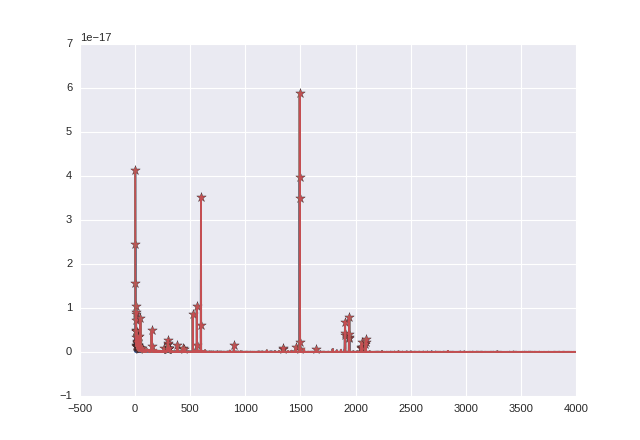

(-500, 4000)

In [14]:
# peaks mph = mean + 3sd
plt.plot(psd.iloc[:,0], psd.iloc[:,1], zorder=1)
plt.scatter(pks.iloc[:,0], pks.iloc[:,1], zorder=2,
           marker='*', c='r', s=80)
plt.xlim(-500,4000)

## Find peaks w/ no mph

In [2]:
y = psd.iloc[:,1]
space = 10
# This is slow AF (29.5s)
ind = detect_peaks(y, mpd=space)
print('%d peaks' %len(ind))

49944 peaks


In [23]:
print('Cut data down to 1 / %d' %(749999 // 49944))

Cut data down to 1 / 15


# Rolling Average?
----

In [30]:
# peaks no threshold
pksnt = psd.iloc[ind, :2]
pksnt.head()

,Hz,Optic_Test-1
14,1.000000,4.140594e-17
25,1.733333,2.460699e-17
37,2.533333,1.567874e-17
56,3.800000,1.039222e-17
74,5.000000,8.596849e-18


From `pksnt.index` we need to get 
```python
c = pksnt.index # center of window
k = (window_size -1) // 2
mean(psd.iloc[ (c-k:c+k), i]) + 3 * std(psd.iloc[c-k:c+k, i])
```

In [34]:
# test single point/window
k = 10 # win size = 2K+1
c = 14
col = 1
nsd = 3
# np.mean(psd.iloc[c-k:c+k, col])
win = psd.iloc[c-k:c+k, col]
np.mean(win) + nsd * np.std(win)

5.595871298461335e-17

## Subtraction by local threshold (works)

In [5]:
# peaks no threshold
pksnt = psd.iloc[ind, :2]
pksnt.head()

k = 10 # win size = 2K+1
col = 1
nsd = 3
win_mph = []
for i in pksnt.index:
    # need a check here for index-out-of-bounds
    # if i < k: skip i?
    win = psd.iloc[i-k:i+k, col]
    mph = np.mean(win) + nsd * np.std(win)
    win_mph.append(mph)

# subtract each point by its threshold
dx = pksnt.iloc[:,1] - win_mph
pkswn = dx[dx > 0]

## Index OOB: Exclude Ends

In [14]:
# simplify the logic
k = 5
index = np.arange(0, 20)
accepted_indexes = []
windows = []

for i in index:
    # if the window of i does not grab an index out of bounds
    if not ( (i - k < 0) or (i + k >= len(index)) ):
        accepted_indexes.append(i)
        win = index[i-k:i+k]
        windows.append(win)

print(accepted_indexes)
print(windows)

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16]), array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17]), array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])]


In [ ]:
# Combine w/ above
# pksnt = output df of psd.iloc[ind], ind from detect_peaks(mph=0)
# psd = regular psd df
# pkswn = windowed peaks df

k = 10 # win size = 2K+1
col = 1
nsd = 3
win_mph = []

index = pksnt.index
for i in index:
    # if the window of i does not grab an index out of bounds
    if not ( (i - k < 0) or (i + k >= len(index)) ):
        win = psd.iloc[i-k:i+k, col]
        mph = np.mean(win) + nsd * np.std(win)
        win_mph.append(mph)
        

# subtract each point by its threshold
dx = pksnt.iloc[:,1] - win_mph
pkswn = dx[dx > 0]

## Assemble Peaks DF

In [40]:
# maybe do the same thing as in the script with a zeros df
ix1 = dx[dx > 0].index
ix2 = dx[dx > 0].index - 100 # shift indexes to create 2 distinct peak scans

# could use pksnt, but need psd here b/c we're shifting the index
tmp = pd.DataFrame(np.zeros_like(psd), 
                index=psd.index, columns=psd.columns)
tmp.iloc[ix1, 1] = psd.iloc[ix1, 1]
tmp.iloc[ix2, 2] = psd.iloc[ix2, 2]

# rm zero rows
tmp = tmp.loc[(tmp!=0).any(axis=1)]
tmp.iloc[:,0] = psd.loc[tmp.index]
tmp.head()

,Hz,Optic_Test-1,Optic_Test-2
16,1.133333,0.000000e+00,1.142701e-17
29,2.000000,0.000000e+00,4.642638e-18
116,7.800000,9.089901e-18,0.000000e+00
129,8.666667,7.211580e-18,0.000000e+00
257,17.200000,0.000000e+00,1.453541e-18


In [48]:
print len(ix1)
print len(ix2)

10735
10735


# Function Tests

<br>
## windowed_peak_threshold

In [3]:
# test data
psd = pd.read_csv("test_data/optic_test/optic_test_z_psd.csv")

In [2]:
# Get single run peaks data (used extensively in this nb)
y = psd.iloc[:,1]
tsd = 3
space = 50

p, win_mph = windowed_peak_threshold(y=y, thresh_sd=tsd, space=space,
                                    ret_thresh=True)

NameError: name 'windowed_peak_threshold' is not defined

In [69]:
print type(p)
print type(win_mph)

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [72]:
print len(x)
print len(win_mph[p.index])

109
109


In [67]:
h = psd.iloc[p.index[-1], 0]
print('Max freq w/ detected peak: %dHz' %h)

Max freq w/ detected peak: 724Hz


In [148]:
def windowed_peak_threshold(y, thresh_sd, space, ret_thresh = False, 
                             ind_only = True):
    """ Compare each value of signal y to a moving windowed threshold based on
    thresh_sd and k.

    In
    ---
    y : 1D array-like
        signal, probably a pd.Series, single psd recording
    thresh_sd : num
        threshold for window = mean(y) + thresh_sd * std(y)
    space : int
        minimum peak distance (in data points), passed to detect_peaks
        window width +/- 1 (width = space // 2 +1)
    ret_thresh : bool, optional (def = False) 
        also return threshold values/indexes for each peak
        >>> peaks, mph = windowed_peak_threshold(..)

    Out
    ----
    peaks: pd.Series
        Peaks and their indices corresponding to the index of y
    win_mph: pd.Series
        Threshold/index for each peak. Threshold < peak 

    Notes
    -----
    The index of y must be its rownumber/integer location. So DON'T pull y 
    from a df where you have the index/rownames assigned to the x-axis
    (eg, Hz)
    """
    # k should probs just equal space, assuming that mpd is one directional NOTE check this
    k = space
    # k = space // 2
    win_mph = []
    win_ind = []

    # forget about height, give me indexes of all the local maxima 
    # based on space
    ind = detect_peaks(y, mph = None, mpd = space)

    for i in ind:
        # if the window of i does not grab an ind out of bounds
        if not ( (i - k < 0) or (i + k >= len(y)) ):
            win = y[i-k : i+k+1]
            mph = np.mean(win) + thresh_sd * np.std(win)
            win_mph.append(mph)
            # so that len(y[win_ind]) == len(win_mph)
            win_ind.append(i)

    # machine, pls
    win_mph = pd.Series(win_mph, index=win_ind)

    # subtract each point by its threshold
    p = y[win_mph.index]
    dx = p - win_mph
    peaks = p[dx > 0]

    
    if ret_thresh and not ind_only:
        return peaks, win_mph
    elif ind_only:
        return peaks.index
    else:
        return peaks


### iterate across a dataframe

- DON'T set df index to Hz column, windowed.peaks relies on rownumber indexes

In [12]:
%run -i 'scratch.py'

In [5]:
tsd = 3
space = 50

pks = get_windowed_peaks(psd, tsd, space)

In [214]:
pks.head()

,Hz,Optic_Test-1,Optic_Test-2,Optic_Test-3
199,13.333333,9.451167e-18,NaN,NaN
287,19.200000,NaN,3.826606e-18,NaN
296,19.800000,4.915654e-18,NaN,NaN
298,19.933333,NaN,NaN,4.702472e-18
371,24.800000,NaN,4.788997e-18,NaN


In [13]:
f = 'header-test.csv'
info = '# this is a test header'

make_headertest(f)
add_header(info, f)

##  plots

In [79]:
p.max()

2.2944170802900002e-17

[(-4.3637516538500003e-19, 1.8327756946170002e-17), (20, 744.133333333)]

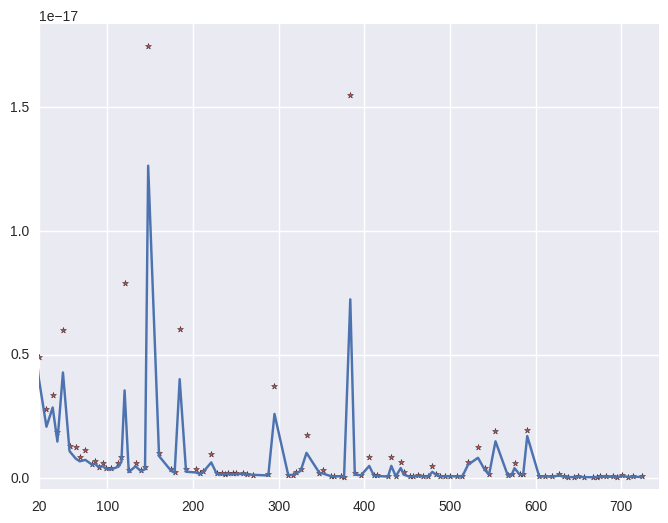

In [138]:
# machine pls make presentable plot
x = psd.iloc[p.index,0] # oh shit waddup
fig, ax = plt.subplots(
    figsize=(8,6)
)

# plt.plot(x, win_mph[p.index], 'r')
ax.plot(x, win_mph[p.index],'b')

ax.scatter(x, p
           ,c='r',marker='*'
)

## hat souls
# x ax
xpad = 20
xwin = 20 #hz
x_lim = ((xwin, x.iloc[-1] + xpad))

# xtra ticks
xt = ax.xaxis.get_majorticklocs()
xt = np.append(xt, xwin)
xt.sort()
ax.xaxis.set_ticks(xt)

# y ax
pvis = p[x[x>=xwin].index]
ypad = 0.05 * pvis.max()
y_lim = ((-ypad / 2, pvis.max() + ypad))


ax.set(
     xlim=x_lim ,ylim=y_lim 
)

In [185]:
# Some seaborn style shit
# st = 'whitegrid'
st = 'darkgrid' # default
# st = 'ticks'
# st = 'white'
# st = 'dark'

pa = 'Set2'

sns.set(style=st, palette=pa)

In [ ]:
def rolling_trh(y, thresh_sd, k):
    win_trh = []
    ind = y.index
    
    for i in ind:        
        # if the window of i does not grab an ind out of bounds
        if not ( (i - k < 0) or (i + k+1 >= len(ind)) ):
            win = y[i-k : i+k+1]
            trh = np.mean(win) + thresh_sd * np.std(win)
            win_trh.append(trh)
        else: # 
            win_trh.append(np.nan)
    
    win_trh = pd.Series(win_trh, index=ind)
    return win_trh

In [ ]:
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

<IPython.core.display.Javascript object>


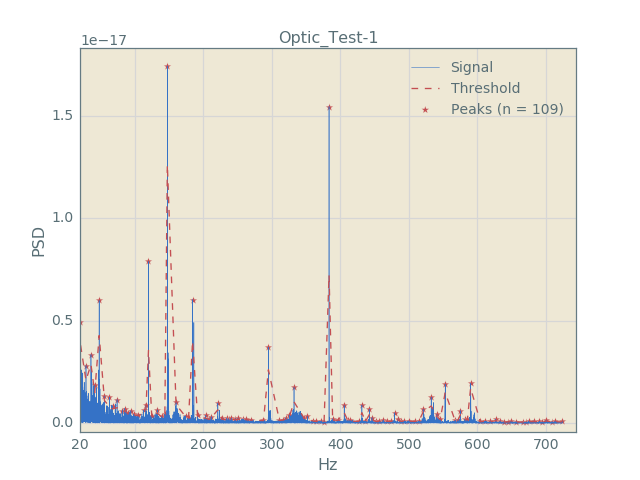

In [28]:
# machine pls make presentable plot
x = psd.iloc[p.index,0] # oh shit waddup

def plot_souls(figsize=(8,6)):
    fig, ax = plt.subplots(
        figsize=figsize
    )
    
    y = psd.iloc[:x.index[-1] + 1, 1] # psd sig, +1 b/c range indexing
    yx = psd.iloc[y.index, 0] # bigger hz
    
    plt.plot(yx, y, 'b'
             , label = 'Signal'
             , lw = 0.5
    )
    
    trh = rolling_trh(y, tsd, space // 2)
    ax.plot(x, win_mph[p.index],'r--'
            ,label='Threshold'
    )

    ax.scatter(x, p
               ,c='r', marker='*', s=50
               ,label='Peaks (n = ' + str(len(p)) + ')' 
    )
    

    
    return fig, ax
def hat_souls(ax):
    ## hat souls
    # x ax
    xpad = 20
    xwin = 20 #hz
    x_lim = ((xwin, x.iloc[-1] + xpad))

    # xtra ticks
    xt = ax.xaxis.get_majorticklocs()
    xt = np.append(xt, xwin)
    xt.sort()
    ax.xaxis.set_ticks(xt)

    # y ax
    pvis = p[x[x>=xwin].index]
    ypad = 0.05 * pvis.max()
    y_lim = ((-ypad / 2, pvis.max() + ypad))


    ax.set(
         xlim = x_lim ,ylim=y_lim
        ,ylabel = 'PSD'
        ,xlabel = x.name
        ,title = p.name
    )
    
    # plt.legend() is equivalent to
    # handles, labels = ax.get_legend_handles_labels()
    # ax.legend(handles, labels)
    plt.legend()

fig, ax = plot_souls()
hat_souls(ax)

# sns.despine()

#### stem

<IPython.core.display.Javascript object>


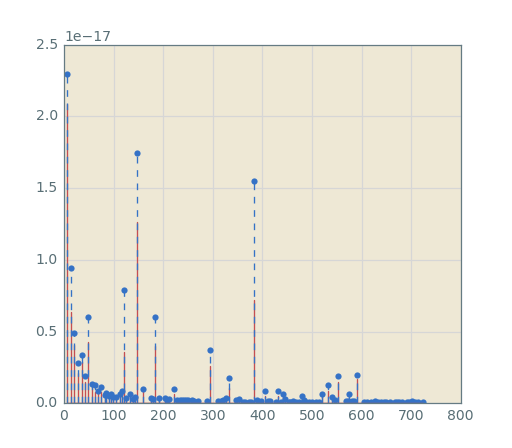

[]

In [43]:
# matplotlib stem method
x = psd.iloc[p.index,0] # oh shit waddup

fig, ax = plt.subplots()

# plt.plot(x, win_mph[p.index], 'r')
ax.stem(x, win_mph[p.index], 'r'
       , markerfmt=' ')
ax.stem(x, p, 'b--')
ax.set(
#     xlim=((383.5,383.7))
)

#### TODO: speed test w/ space

# Learning Data Structures

In [1]:
# test data
psd = pd.read_csv("test_data/optic_test/optic_test_z_psd.csv")

In [42]:
# pd.Series
s = psd.iloc[:,1]

# Series name is assigned automatically when taking 1D slices of DataFrame
print('Series name: %s' %s.name)

# auto assigned index is basically index in original df/Series at creation
# we could assign the index of any series, or the df, to hz (common x axis)
s.index = psd.iloc[:,0]
i = s.index
print(i[:5])

# we can still preserve our location slicing 'iloc' 'integer location'
print(s.index[4])
print(s.iloc[4])

Series name: Optic_Test-1
Float64Index([0.0666666666667, 0.133333333333, 0.2, 0.266666666667,
              0.333333333333],
             dtype='float64', name=u'Hz')
0.333333333333
5.92999849925e-19


# Learning Ploting

In [1]:
%matplotlib inline

## Stems on points

### Stems

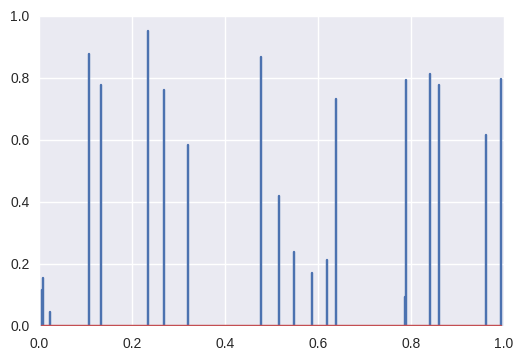

In [5]:
import matplotlib.pyplot as plt
import numpy as np

x, y = np.random.random((2, 20))

fig, ax = plt.subplots()
ax.stem(x, y, markerfmt=' ')
plt.show()

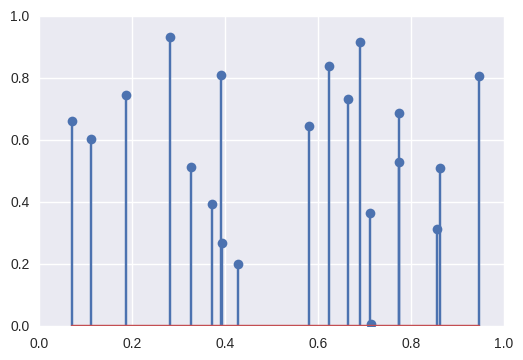

In [8]:
# for dots on lines rm markerfmt
import matplotlib.pyplot as plt
import numpy as np

x, y = np.random.random((2, 20))

fig, ax = plt.subplots()
ax.stem(x, y)
plt.show()

# investigating detect_peaks

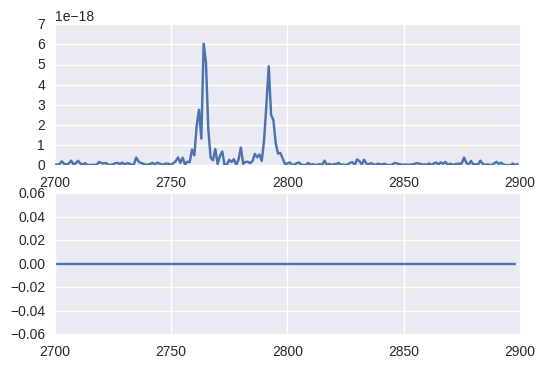

In [26]:
ind = np.arange(2700,2900)
x = psd.iloc[ind, 1]

dx = x[1:] - x[:-1]

fig, ax = plt.subplots(2)
ax[0].plot(x)
ax[1].plot(dx)
# what the fuck is going on?

<IPython.core.display.Javascript object>


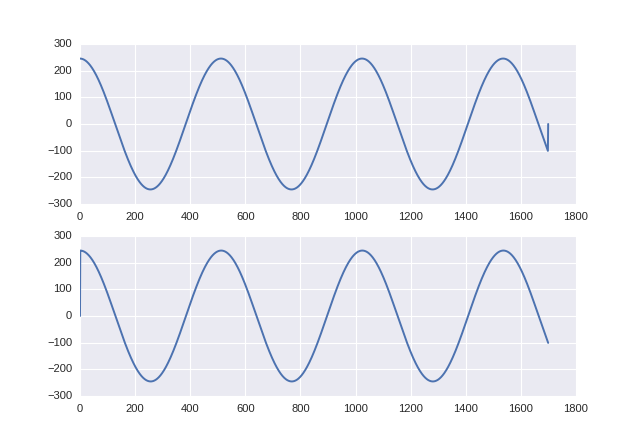

In [15]:
# N = 1024
N = 1700
signal=[np.sin(2*np.pi*i/512)*20000+30000 for i in np.arange(0,N,1)]
signal = np.array(signal)

# find indices of all peaks
# dx = x[1:] - x[:-1]
dx = signal[1:] - signal[:-1]


fig, axs = plt.subplots(2)
# axs[0].plot(signal)
axs[0].plot(np.hstack((dx,0)))
axs[1].plot(np.hstack((0,dx)))

In [8]:
# if not edge, rising edge, falling edge
ine, ire, ife = np.array([[], [], []], dtype=int)

#if edge.lower() in ['rising', 'both']:
ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]

ind = np.unique(np.hstack((ine, ire, ife)))

ind

array([ 128,  640, 1023])

In [9]:
np.hstack((dx, 0))

array([ 245.43076571,  245.39380474,  245.31988837, ...,  245.31988837,
        245.39380474,    0.        ])

In [11]:
np.hstack((0, dx))

array([   0.        ,  245.43076571,  245.39380474, ...,  245.20902772,
        245.31988837,  245.39380474])

In [10]:
dx

array([ 245.43076571,  245.39380474,  245.31988837, ...,  245.20902772,
        245.31988837,  245.39380474])

In [ ]:
# first and last values of x cannot be peaks
if ind.size and ind[0] == 0:
    ind = ind[1:]
if ind.size and ind[-1] == x.size-1:
    ind = ind[:-1]
